### Imports

In [1]:
import librosa  # need pip install librosa
import time
import pickle
import numpy as np
from random import random, shuffle
import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size' : 12.5})  # for confusion plot
from pydub import AudioSegment
import pprint
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif

pp = pprint.PrettyPrinter(indent = 4)

### Loading features + combining

In [2]:
with open('../chorus_features.p', 'rb') as f:
    c_features = pickle.load(f)
with open('../verse_features.p', 'rb') as f:
    v_features = pickle.load(f)
with open('../feature_names.p', 'rb') as f:
    feature_names = pickle.load(f)   
with open('../song_names.p', 'rb') as f:
    song_names = pickle.load(f)

In [3]:
def combine(c_features, v_features, song_names=song_names):
    """
    combine chorus and verse features in one long list (random) with labels
    """
    assert len(c_features)==len(v_features)==len(song_names)
    seed = random.Random(random.randint(1,1000))  # Shuffle with seed to assure song names are still in order
    
    total = len(c_features)*2
    random_list = [True]*int(np.floor(total/2))+[False]*int(np.ceil(total/2))
    shuffle(random_list)
    
    seed.shuffle(c_features)
    seed.shuffle(v_features)
    c_features = list(c_features)
    v_features = list(v_features)
    
    song_names_chorus = list(song_names)
    song_names_verse = list(song_names)
    seed.shuffle(song_names_chorus)
    seed.shuffle(song_names_verse)
    
    combined = []
    labels = []
    names = []
    for i in random_list:
        if i:
            combined.append(c_features.pop())
            labels.append(0)
            names.append(song_names_chorus.pop()+'_chorus')
        else:
            combined.append(v_features.pop())
            labels.append(1)
            names.append(song_names_verse.pop()+'_verse')

#     print(list(zip(labels, names))[:15])        
            
    return combined, labels, names


In [4]:
print('Combining chorus and verse features')

features, labels, names = combine(c_features, v_features)
# features = features[:len(features)//2]
# labels = labels[:len(labels)//2]
print(np.shape(features))

Combining chorus and verse features
(340, 168)


##### Feature Selection

In [5]:
feature_selector = SelectPercentile(f_classif, percentile=60)
reduced_features = feature_selector.fit_transform(features, labels)

##### Fix feature names vector with selected features

In [6]:
feature_mask = feature_selector.get_support() #list of booleans for each feature (True: is included)
reduced_feature_names = [] #list of reduced feature names

for used, feature in zip(feature_mask, feature_names):
    if used: #If feature is selected, add to new list of feature names
        reduced_feature_names.append(feature)

### Classification and evaluation
#### K-fold Cross Validation:

In [7]:
n_splits = len(reduced_features)//2  # leave-2-out
print('Applying cross validation with {} splits...'.format(n_splits))

clf = RandomForestClassifier(n_estimators=300, max_depth=80) #Classifier
predictions = cross_val_predict(clf, reduced_features, labels, cv=n_splits) 
print('Done!')

Applying cross validation with 170 splits...
Done!


In [8]:
# Accuracy
scores = predictions == labels
accuracy = (sum(scores)/len(labels))*100
print('accuracy: {:.2f}% ({})'.format(accuracy, sum(scores)))

# Misclassification
wrongs = [i for i, x in enumerate(scores) if not x]
wrong_names = sorted([names[i] for i in wrongs])
print('Misclassified: {:.2f}% ({})'.format(100-accuracy, len(wrongs)))
pp.pprint(wrong_names)

accuracy: 91.47% (311)
Misclassified: 8.53% (29)
[   'AnotherOneBitesTheDust_verse',
    'BillieJean_chorus',
    'BillieJean_verse',
    'ComeTogether_verse',
    'DevilInHerHeart_chorus',
    'DirtyDiana_verse',
    'EleanorRigby_chorus',
    'FriendsWillBeFriends_verse',
    'GoldenSlumbers_verse',
    'GotToBeThere_verse',
    'Help_chorus',
    'HomeAgain_verse',
    'IAmTheWalrus_verse',
    'IMeMine_verse',
    'ItWontBeLong_verse',
    'ItsOnlyLove_verse',
    'MagicalMysteryTour_chorus',
    'Money For Nothing_chorus',
    'NoOneButYou_verse',
    'OffTheWall_verse',
    'PrincesOfTheUniverse_verse',
    'SavoyTruffle_chorus',
    'TheLoveYouSave_verse',
    'Wait_verse',
    'Walk Of Life_verse',
    'WayOverYonder_verse',
    'WhenIGetHome_chorus',
    'WhoWantsToLiveForever_chorus',
    'YouRockMyWorld_verse']


#### One fold train/test split test:

In [9]:
random_state = random.randint(1,1000)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, \
                                                    test_size=0.1, random_state=random_state)
names_train, names_test,_,_ = train_test_split(names, np.arange(len(names)), \
                                               test_size=0.1, random_state=random_state)

In [11]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
kappa = cohen_kappa_score(y1=y_test, y2=y_pred)

In [12]:
print('Accuracy: {}\nCohen\'s kappa: {}'.format(accuracy, kappa))

Accuracy: 0.8529411764705882
Cohen's kappa: 0.7058823529411764


In [13]:
wrongs = [i for i, x in enumerate(y_pred == y_test) if not x]
wrong_names = [names_test[i] for i in wrongs]
print('Misclassified:',wrong_names)

Misclassified: ['Help_chorus', 'ShesLeavingHome_chorus', 'WannaBeStartinSomethin_chorus', 'TheLoveYouSave_verse', 'StrawberryFieldsForever_chorus']


### Feature importance

In [14]:
#Tuples of feature names and their importance, sorted from low to high
features_with_importance = sorted(list(zip(reduced_feature_names, clf.feature_importances_)),\
                                  key=lambda x:x[1])

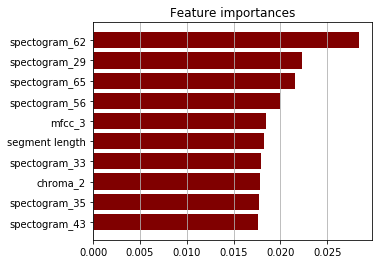

In [15]:
#Number of features to plot
show_n_features = 10
assert show_n_features > 0

#Plot importances
plt.figure(figsize=(5,np.ceil(show_n_features/2.5)))
plt.title("Feature importances")
plt.barh([x[0] for x in features_with_importance[-show_n_features:]],
         [x[1] for x in features_with_importance[-show_n_features:]],
         color="#800000")
plt.grid(axis='x')
plt.show()

In [16]:
# Plotting method for confusion matrices
# From sklearn example code snippets

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Reds):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap);
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='{} confusion matrix'.format('Normalized' if normalize else ''),
           ylabel='True label',
           xlabel='Predicted label');

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor");

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", size=20)
    fig.tight_layout()
    return ax


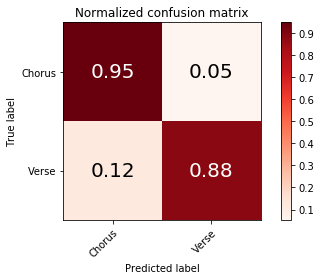

In [17]:
plot_confusion_matrix(labels, predictions, classes=['Chorus', 'Verse'], normalize=True);